# Complex Conductivity Calculation
This file simulates the Al/Ti/Al trilayer discussed in
[Zhao et al. 2018](https://doi.org/10.1088/1361-6668/aa94b7) for two different
aluminum layer thicknesses and reproduces figure 6.

We start with the standard import statements. (matplotlib is not a requirement
for this library, so it must be installed separately for this notebook to run).
The logging module is also initialized to show details about the calculation.

In [1]:
import logging
import numpy as np
from scipy.constants import hbar, k
from matplotlib import pyplot as plt
from superconductivity.utils import BCS
from superconductivity.multilayer import (
    Stack, Superconductor, complex_conductivity)

logging.basicConfig(level=logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

%matplotlib inline

To define a bilayer, we need the thickness, transition temperature,
Debye temperature, diffusion constant, and resistivity for each layer. These
numbers are taken from the paper.

Here, we define two different titanium thicknesses to iterate over.

In [2]:
# Ti parameters
# thickness [m]
d_ti = [200e-9, 25e-9]
# transition temperature [K]
tc_ti = 0.4
# Debye temperature [K]
td_ti = 420  # not actually used since we fix nc later
# coherence length [m]
xi_ti = 110e-9
# diffusion constant [m^2 / s]
dc_ti = 2 * np.pi * xi_ti**2 * tc_ti * k / hbar
# resistivity [Ohm m]
rho_ti = 1 / 3 * 1e-6

# Al parameters
# thickness [m]
d_al = 25e-9
# transition temperature [K]
tc_al = 1.2
# Debye temperature [K]
td_al = 433  # not actually used since we fix nc later
# coherence length [m]
xi_al = 170e-9
# diffusion constant [m^2 / s]
dc_al = 2 * np.pi * xi_al**2 * tc_al * k / hbar
# resistivity [Ohm m]
rho_al = 1 / 180 * 1e-6

We also need to know the boundary resistance between layers and the temperature.

In [3]:
# boundary resistance [Ohm m^2]
rb = 0.01 * rho_al * xi_al
# temperature [K]
t = 0.1

The simulation is done by first creating the superconductor objects, setting
some simulation parameters, adding them to a stack object, and then calling the
complex_conductivity() function.

INFO:superconductivity.multilayer.functions:Computing the complex conductivity.
INFO:superconductivity.multilayer.stack:Computing the order parameter for a stack.
DEBUG:superconductivity.multilayer.stack:Iteration: 1 :: R: 0.159664
DEBUG:superconductivity.multilayer.stack:Iteration: 2 :: R: 0.0259528
DEBUG:superconductivity.multilayer.stack:Iteration: 3 :: R: 0.0133177
DEBUG:superconductivity.multilayer.stack:Iteration: 4 :: R: 0.00640819
DEBUG:superconductivity.multilayer.stack:Iteration: 5 :: R: 0.00283738
DEBUG:superconductivity.multilayer.stack:Iteration: 6 :: R: 0.00130263
DEBUG:superconductivity.multilayer.stack:Iteration: 7 :: R: 0.000919712
INFO:superconductivity.multilayer.stack:Order parameter computed.
INFO:superconductivity.multilayer.stack:Computing the pair angle for a stack.
INFO:superconductivity.multilayer.stack:Pair angle computed.
INFO:superconductivity.multilayer.functions:Computing the complex conductivity.
INFO:superconductivity.multilayer.stack:Computing the orde

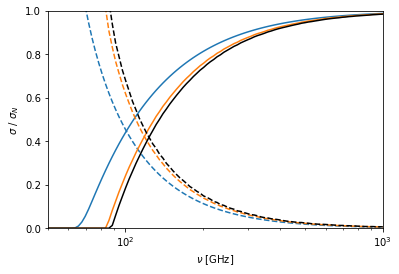

In [4]:
# Define the aluminum layer and the simulation frequencies.
al = Superconductor(d_al, rho_al, t, td_al, tc_al, dc_al)
frequencies = np.logspace(np.log10(50e9), np.log10(1000e9), 100)

figure, axes = plt.subplots()
for i, d in enumerate(d_ti):
    # Define the titanium layer.
    ti = Superconductor(d, rho_ti, t, td_ti, tc_ti, dc_ti)

    # Fix the number of Matsubara frequencies to what is used in the paper.
    # Typically, the number of frequencies used is determined from the Debye
    # temperature for the material.
    al.nc = 125
    ti.nc = 125

    # Add the superconductors to the trilayer
    stack = Stack([al, ti, al], [rb, rb])

    # The paper also uses a lower relative convergence tolerance and does not
    # use Steffensen's iterations to speed up the convergence.
    stack.rtol = 1e-3
    stack.speedup = False

    # Do the simulation.
    sigma = complex_conductivity(stack, frequencies)

    # Plot the results.
    axes.semilogx(frequencies / 1e9, sigma[:, 0].real, color=f"C{i}")
    axes.semilogx(frequencies / 1e9, -sigma[:, 0].imag, linestyle='--',
                  color=f"C{i}")

# Compute bulk aluminum conductivity.
stack = Stack(al, [])
sigma = complex_conductivity(stack, frequencies)

# Finish the plot.
axes.semilogx(frequencies / 1e9, sigma[:, 0].real, color="k")
axes.semilogx(frequencies / 1e9, -sigma[:, 0].imag, linestyle='--', color="k")
axes.set_ylim(0, 1)
axes.set_xlim(50, 1000)
axes.set_ylabel(r"$\sigma$ / $\sigma_N$")
axes.set_xlabel(r"$\nu$ [GHz]");